# Cell 1: Markdown


In [1]:
"""
# FAISS Vector Indexing

This notebook demonstrates:
1. Creating embeddings for documents
2. Building FAISS indices (FlatIP, IVFFlat, HNSW)
3. Comparing index types
4. Performing semantic search
5. Saving and loading indices

**Prerequisites:** Run `01_data_preparation.ipynb` first.
"""

'\n# FAISS Vector Indexing\n\nThis notebook demonstrates:\n1. Creating embeddings for documents\n2. Building FAISS indices (FlatIP, IVFFlat, HNSW)\n3. Comparing index types\n4. Performing semantic search\n5. Saving and loading indices\n\n**Prerequisites:** Run `01_data_preparation.ipynb` first.\n'

# Cell 2: Setup

In [2]:

import sys
sys.path.append('..')

import numpy as np
from src.data_loader import DocumentationLoader
from src.embedding_engine import EmbeddingEngine
from src.vector_store import FAISSVectorStore
from src.search_engine import SemanticSearchEngine
import time

# Cell 3: Load documents

In [3]:

loader = DocumentationLoader()
docs = loader.load_documents()
print(f"Loaded {len(docs)} documents")

✓ Loaded 15 documents from data\processed\sample_docs.json
Loaded 15 documents


# Cell 4: Generate embeddings

In [4]:
print("\n--- Generating Embeddings ---")
embedder = EmbeddingEngine()
embeddings = embedder.embed_documents(docs)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Data type: {embeddings.dtype}")


--- Generating Embeddings ---
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
✓ Model loaded. Embedding dimension: 384
Encoding 15 documents...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (15, 384)
Embedding dimension: 384
Data type: float32


# Cell 5: Markdown


In [5]:
"""
## Index Type 1: IndexFlatIP (Exact Search)

- **Pros:** 100% accurate, simple, no training needed
- **Cons:** Slower for large datasets (linear search)
- **Use case:** Small to medium datasets (<10k vectors), when accuracy is critical
"""

'\n## Index Type 1: IndexFlatIP (Exact Search)\n\n- **Pros:** 100% accurate, simple, no training needed\n- **Cons:** Slower for large datasets (linear search)\n- **Use case:** Small to medium datasets (<10k vectors), when accuracy is critical\n'

# Cell 6: Create FlatIP index

In [6]:
print("\n" + "="*60)
print("Creating IndexFlatIP")
print("="*60)

store_flat = FAISSVectorStore(embedding_dim=384, index_type="FlatIP")
store_flat.add_documents(embeddings, docs)

print("\nStats:", store_flat.get_stats())


Creating IndexFlatIP

Initializing FAISS Index: FlatIP
✓ Created IndexFlatIP (exact search, cosine similarity)

Adding 15 vectors to index...
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15

Stats: {'index_type': 'FlatIP', 'embedding_dim': 384, 'n_vectors': 15, 'n_documents': 15, 'is_trained': True}


# Cell 7: Test FlatIP search

In [7]:
query_text = "How do I deploy serverless applications on Azure?"
query_emb = embedder.embed(query_text, show_progress=False)

print(f"\nQuery: '{query_text}'")
print("\n--- Search Results (FlatIP) ---")

results_flat = store_flat.search_with_documents(query_emb, k=3)
for i, res in enumerate(results_flat, 1):
    print(f"\n[{i}] Score: {res['score']:.4f}")
    print(f"    Title: {res['document']['title']}")
    print(f"    Category: {res['document']['category']}")


Query: 'How do I deploy serverless applications on Azure?'

--- Search Results (FlatIP) ---

[1] Score: 0.4210
    Title: Azure DevOps Python API
    Category: Azure DevOps

[2] Score: 0.4205
    Title: Azure Machine Learning Python SDK
    Category: Azure AI/ML

[3] Score: 0.4096
    Title: Python Azure Functions - Getting Started
    Category: Azure Functions


# Cell 8: Markdown


In [8]:
"""
## Index Type 2: IndexIVFFlat (Fast Approximate Search)

- **Pros:** Much faster than FlatIP for large datasets
- **Cons:** Requires training, slightly less accurate
- **Use case:** Large datasets (>10k vectors), when speed matters
- **Parameters:** 
  - `nlist`: Number of clusters (typically sqrt(n_vectors))
  - `nprobe`: Number of clusters to search (accuracy/speed tradeoff)
"""

'\n## Index Type 2: IndexIVFFlat (Fast Approximate Search)\n\n- **Pros:** Much faster than FlatIP for large datasets\n- **Cons:** Requires training, slightly less accurate\n- **Use case:** Large datasets (>10k vectors), when speed matters\n- **Parameters:** \n  - `nlist`: Number of clusters (typically sqrt(n_vectors))\n  - `nprobe`: Number of clusters to search (accuracy/speed tradeoff)\n'

# Cell 9: Create IVFFlat index

In [10]:
print("\n" + "="*60)
print("Creating IndexIVFFlat")
print("="*60)

# Create IVFFlat index (index created automatically in __init__)
store_ivf = FAISSVectorStore(embedding_dim=384, index_type="IVFFlat")

# Train and add documents (training happens automatically in add_documents if needed)
store_ivf.add_documents(embeddings, docs)

print("\nStats:", store_ivf.get_stats())



Creating IndexIVFFlat

Initializing FAISS Index: IVFFlat
✓ Created IndexIVFFlat
  - nlist (clusters): 10
  - Requires training before use

Adding 15 vectors to index...
Training IVFFlat index on 15 vectors...
✓ Index trained successfully
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15

Stats: {'index_type': 'IVFFlat', 'embedding_dim': 384, 'n_vectors': 15, 'n_documents': 15, 'is_trained': True, 'nlist': 10, 'nprobe': 1}


# Cell 10: Test IVFFlat search

In [11]:
print(f"\nQuery: '{query_text}'")
print("\n--- Search Results (IVFFlat) ---")

results_ivf = store_ivf.search_with_documents(query_emb, k=3, nprobe=3)
for i, res in enumerate(results_ivf, 1):
    print(f"\n[{i}] Score: {res['score']:.4f}")
    print(f"    Title: {res['document']['title']}")
    print(f"    Category: {res['document']['category']}")


Query: 'How do I deploy serverless applications on Azure?'

--- Search Results (IVFFlat) ---

[1] Score: 1.1580
    Title: Azure DevOps Python API
    Category: Azure DevOps

[2] Score: 1.1807
    Title: Python Azure Functions - Getting Started
    Category: Azure Functions

[3] Score: 1.2542
    Title: Azure Blob Storage Python SDK
    Category: Azure Storage


# Cell 11: Markdown


In [12]:
"""
## Index Type 3: IndexHNSWFlat (High-Performance Approximate Search)

- **Pros:** Very fast search, good accuracy, no training needed
- **Cons:** Slower indexing, more memory
- **Use case:** Production systems requiring low latency
- **Parameters:**
  - `M`: Number of connections (higher = better quality, more memory)
  - `efSearch`: Search accuracy (higher = more accurate, slower)
"""

'\n## Index Type 3: IndexHNSWFlat (High-Performance Approximate Search)\n\n- **Pros:** Very fast search, good accuracy, no training needed\n- **Cons:** Slower indexing, more memory\n- **Use case:** Production systems requiring low latency\n- **Parameters:**\n  - `M`: Number of connections (higher = better quality, more memory)\n  - `efSearch`: Search accuracy (higher = more accurate, slower)\n'

# Cell 12: Create HNSW index

In [13]:
print("\n" + "="*60)
print("Creating IndexHNSWFlat")
print("="*60)

store_hnsw = FAISSVectorStore(embedding_dim=384, index_type="HNSW")
store_hnsw.add_documents(embeddings, docs)

print("\nStats:", store_hnsw.get_stats())


Creating IndexHNSWFlat

Initializing FAISS Index: HNSW
✓ Created IndexHNSWFlat (fast approximate search)
  efConstruction: 40, efSearch: 16

Adding 15 vectors to index...
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15

Stats: {'index_type': 'HNSW', 'embedding_dim': 384, 'n_vectors': 15, 'n_documents': 15, 'is_trained': True, 'note': 'HNSW graph-based index (M=32, efSearch=16)'}


# Cell 13: Test HNSW search

In [14]:
print(f"\nQuery: '{query_text}'")
print("\n--- Search Results (HNSW) ---")

results_hnsw = store_hnsw.search_with_documents(query_emb, k=3)
for i, res in enumerate(results_hnsw, 1):
    print(f"\n[{i}] Score: {res['score']:.4f}")
    print(f"    Title: {res['document']['title']}")
    print(f"    Category: {res['document']['category']}")


Query: 'How do I deploy serverless applications on Azure?'

--- Search Results (HNSW) ---

[1] Score: 1.1580
    Title: Azure DevOps Python API
    Category: Azure DevOps

[2] Score: 1.1590
    Title: Azure Machine Learning Python SDK
    Category: Azure AI/ML

[3] Score: 1.1807
    Title: Python Azure Functions - Getting Started
    Category: Azure Functions


# Cell 14: Compare search times


Performance Comparison

Average search time (10 queries):
  IndexFlatIP:   0.036 ms
  IndexIVFFlat:  0.031 ms
  IndexHNSWFlat: 0.036 ms


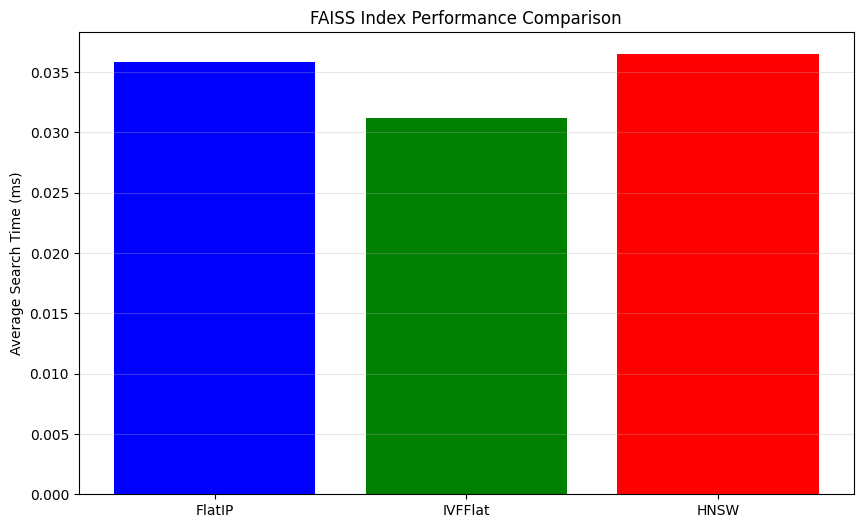

In [17]:
print("\n" + "="*60)
print("Performance Comparison")
print("="*60)

import time

# Run multiple searches and average
n_queries = 10
query_texts = [
    "Azure Functions serverless",
    "Python virtual environments",
    "Machine learning models",
    "Cosmos DB database",
    "Authentication and security"
] * 2

times_flat = []
times_ivf = []
times_hnsw = []

for query in query_texts:
    q_emb = embedder.embed([query], show_progress=False)
    
    # Time FlatIP
    start = time.time()
    _, _ = store_flat.search(q_emb, k=5)
    times_flat.append((time.time() - start) * 1000)
    
    # Time IVFFlat
    start = time.time()
    _, _ = store_ivf.search(q_emb, k=5, nprobe=3)
    times_ivf.append((time.time() - start) * 1000)
    
    # Time HNSW
    start = time.time()
    _, _ = store_hnsw.search(q_emb, k=5)
    times_hnsw.append((time.time() - start) * 1000)

print(f"\nAverage search time ({n_queries} queries):")
print(f"  IndexFlatIP:   {np.mean(times_flat):.3f} ms")
print(f"  IndexIVFFlat:  {np.mean(times_ivf):.3f} ms")
print(f"  IndexHNSWFlat: {np.mean(times_hnsw):.3f} ms")

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(['FlatIP', 'IVFFlat', 'HNSW'], 
        [np.mean(times_flat), np.mean(times_ivf), np.mean(times_hnsw)],
        color=['blue', 'green', 'red'])
plt.ylabel('Average Search Time (ms)')
plt.title('FAISS Index Performance Comparison')
plt.grid(axis='y', alpha=0.3)
plt.show()


# Cell 15: Save indices

In [18]:
print("\n--- Saving Indices ---")
store_flat.save("python_azure_docs")
store_ivf.save("python_azure_docs")
store_hnsw.save("python_azure_docs")



--- Saving Indices ---
✓ Saved index to python_azure_docs.index
✓ Saved metadata to python_azure_docs.pkl
✓ Saved index to python_azure_docs.index
✓ Saved metadata to python_azure_docs.pkl
✓ Saved index to python_azure_docs.index
✓ Saved metadata to python_azure_docs.pkl


# Cell 16: Markdown


In [19]:
"""
## Semantic Search Examples

Try different queries to see semantic understanding:
"""

'\n## Semantic Search Examples\n\nTry different queries to see semantic understanding:\n'

# Cell 17: Test semantic queries

In [20]:
test_queries = [
    "How do I work with cloud storage?",
    "What are Python best practices for code organization?",
    "AI and machine learning services",
    "Asynchronous programming in Python"
]

engine = SemanticSearchEngine(index_type="HNSW")
engine.vector_store = store_hnsw

for query in test_queries:
    print(f"\n{'='*80}")
    print(f"Query: '{query}'")
    print(f"{'='*80}")
    results = engine.search(query, k=2)
    for i, res in enumerate(results, 1):
        print(f"\n[{i}] {res['document']['title']} (Score: {res['score']:.4f})")
        print(f"    {res['document']['text'][:100]}...")


Initializing Semantic Search Engine
Index Type: HNSW
Embedding Model: sentence-transformers/all-MiniLM-L6-v2

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
✓ Model loaded. Embedding dimension: 384

Initializing FAISS Index: HNSW
✓ Created IndexHNSWFlat (fast approximate search)
  efConstruction: 40, efSearch: 16

Query: 'How do I work with cloud storage?'

[1] Azure Blob Storage Python SDK (Score: 0.8614)
    Azure Blob Storage is Microsoft's object storage solution for the cloud. Use the Azure Storage Blobs...

[2] Azure Cosmos DB Python SDK (Score: 1.1767)
    Azure Cosmos DB is a globally distributed, multi-model database service. The Python SDK allows you t...

Query: 'What are Python best practices for code organization?'

[1] Python Virtual Environments Best Practices (Score: 1.2051)
    A virtual environment is a self-contained directory tree that contains a Python installation for a p...

[2] Python Decorators Explained (Score: 1.2759)
    Decorators are a po

# Cell 18: Markdown


In [21]:
"""
## Summary

We've successfully:
1. ✅ Created embeddings for Python/Azure documentation
2. ✅ Built three types of FAISS indices
3. ✅ Compared performance characteristics
4. ✅ Performed semantic search
5. ✅ Saved indices for future use

**Next:** Proceed to `03_performance_benchmarks.ipynb` for detailed analysis.
"""

"\n## Summary\n\nWe've successfully:\n1. ✅ Created embeddings for Python/Azure documentation\n2. ✅ Built three types of FAISS indices\n3. ✅ Compared performance characteristics\n4. ✅ Performed semantic search\n5. ✅ Saved indices for future use\n\n**Next:** Proceed to `03_performance_benchmarks.ipynb` for detailed analysis.\n"